In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *
from lib.analysis.grid_latency import *

####### GRID ROIS #######
# for each recording:
## 1) divide the entire frame of recording into grid of square n_sq x n_sq ROIs
## 2) write these grid square ROIs to file
## 3) take SNRs and latencies to .dat file of each ROI from PhotoZ
## filter out no-response grid squares by SNR cutoff (or manual inspection?)
## write out output file of (ROI center x, ROI center y, SNR, latency)
## analysis: directed graph analysis of latency, 3-D plot of latency, 3-D plot of SNR

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/"

n_sq = 8  # number of pixels of each square edge in the grid.
max_num_rois = 100  # SNR cutoff 
latency_tolerance = 0.35  # ms tolerance to be counted simultaneous

# sets of files in each slice directory -- naming convention
# input
corners_file_prefix_layer = 'corners_layer'  # defines axes of L4 boundaries
electrode_file_prefix = 'electrode'
# also needed: 01_01_01_snr.dat

# output files
rois_file_prefix = 'sq_rois_' + str(n_sq) + "x" + str(n_sq) 
rois_centers_filenames = "roi_centers.txt"

image_data = {}
n_plots = 5000  # show up to how many plots

disable_photoZ_interact = True
initialize_photoZ = False
rewrite_data_files = False
skip_grid_drawing = True

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()

In [4]:

slice_count = 0
missing_la_file_count = 0
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'selected_zda' not in subdir:
        continue
    print(subdir)
    subdir += '/'
    for filename in files:
        fn = filename.split(".")[0]
        if (fn.endswith("_snr") or fn.startswith("SNR")) and "roi" not in fn:
            name_parse = filename[:8]  # of the format 07-01-01
            if fn.startswith("SNR"):
                name_parse = filename[4:11]
            try:
                sep = "_"
                if "-" in name_parse:
                    sep = "-"
                slic, loc, rec = [int(x) for x in name_parse.split(sep)]
            except ValueError:
                print("Could not parse:", name_parse)
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            if rec not in image_data[slic][loc]:
                image_data[slic][loc][rec] = {}
            if subdir not in image_data[slic][loc][rec]:
                image_data[slic][loc][rec][subdir] = {}

            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))
            n_grid_size = int(width / n_sq)  # how many squares will fit along frame edge
            image_data[slic][loc][rec][subdir]['snr_map'] = snr
            print("slice", slic, ", rec", rec)
            
            if skip_grid_drawing:
                continue
            # corners file: 2 points p1, p2 to define the edge along which to measure
            la_file = subdir + corners_file_prefix_layer + '.dat'
            lines = None
            if not os.path.exists(la_file):
                missing_la_file_count += 1
            else:
                print("Processing", la_file)
                slice_count += 1
                with open(la_file, 'r') as f:
                    lines = f.readlines() 
                corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                layer_axes = LayerAxes(corners)
                laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                      laminar_axis_2.get_unit_vector())

                # make our own square ROIs aligned to the list of edges and write them to a .dat file
                ################################
                # Limit # of ROIs by SNR to n highest SNR ROIs so that we can do
                #        smaller ROIs without exceeding 100-ROI-per-file cap
                ################################
                roi_cr = SquareROICreator(layer_axes, roi_width=n_sq, max_num_rois=max_num_rois, snr=snr)
                rois = roi_cr.get_rois()  # list of LaminarROI objects
                roi_centers = roi_cr.get_roi_centers(rounded=True) 
                # print("ROI centers:", roi_centers)
                roi_cr.write_roi_centers_to_file(subdir + "/" + rois_centers_filenames)

                # write these ROIs to file
                roi_fn = roi_cr.write_roi_file(subdir, rois_file_prefix)
                print("Created file:", roi_fn)

                # open stim point roi as a single integer (its diode number) in variable stim_pt
                sp_file = subdir + electrode_file_prefix + '.dat'
                with open(sp_file, 'r') as f:
                    lines = f.readlines()
                stim_pt = int(lines[-1]) # last line is always electrode location
                aux_obj = LaminarROI([stim_pt]).get_points()
                stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                #print("Stim point:", stim_pt)

                # run laminar dist computation
                laminar_distances_obj = LaminarDistance(laminar_axis, rois, stim_pt)
                laminar_distances = laminar_distances_obj.compute_laminar_distances()
                laminar_distances = [round(ld, 2) for ld in laminar_distances]
                #print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                # run laminar dist again with the other axis
                laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                #print('laminar_distances 2:', laminar_distances_2)  # a list of integers with same indexing as rois

                # write averaged laminar distances to file
                avg_laminar_distances = [round(
                    (laminar_distances[i] + laminar_distances_2[i]) / 2,
                    2)
                                        for i in range(len(laminar_distances))]
                #print('laminar_distances averaged :', avg_laminar_distances) 
                ld_filename_base = la_file[:-4] + "_"
                laminar_distances_obj.write_laminar_distance_file(ld_filename_base, avg_laminar_distances)

                #image_data[slic][loc][rec][subdir] = {
                #    'snr': snr,
                #    'filename': filename}

                # Now that the data is stored, show intermediate computations in plot
                if n_plots > 0:
                    lines = [laminar_axis.get_line_repr(),
                             laminar_axis_2.get_line_repr()]
                    line_colors = ['red', 'yellow']
                    linewidths = [4,4]
                    other_colors = ['red', 'green', 'blue', 'white', 'purple']
                    roi_colors = []

                    # laminar aux lines
                    uv = laminar_axis.get_unit_vector()
                    for i in range(len(laminar_distances)):
                        ld = laminar_distances[i]
                        jiggle = i - int(len(laminar_distances) / 2)
                        uv_perp = Line(laminar_axis.get_start_point(), 
                                       laminar_axis_2.get_start_point()).get_unit_vector()
                        stim_proxy_pt = [stim_pt[0] - jiggle * uv_perp[0], 
                                         stim_pt[1] - jiggle * uv_perp[1]]
                        measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                        lines.append([measure_vector, stim_proxy_pt])
                        this_color = other_colors[i % len(other_colors)]
                        line_colors.append(this_color)
                        roi_colors.append(this_color)
                        linewidths.append(1)

                    GridVisualization(snr, stim_pt, roi_centers, layer_axes.get_corners(),
                                      lines, line_colors, linewidths,
                                      rois, roi_colors,
                                      save_dir=subdir+"GridVisual1"+name_parse+'.png')
                    n_plots -= 1

print("\tslice directory count:", slice_count)
print("\tmissing_la_file_count:", missing_la_file_count)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01
slice 2 , rec 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03
slice 2 , rec 3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02
slice 2 , rec 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01
slice 3 , rec 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01
slice 3 , rec 1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02
slice 3 , rec 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12
slice 3 , rec 12
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-2

In [5]:
## 3) take SNRs and latencies to .dat file of each ROI from PhotoZ
slice_count = 0
missing_roi_file_count = 0
if not disable_photoZ_interact:
    for subdir, dirs, files in os.walk(data_dir):
        if 'notUsable' in subdir:
            continue
        if 'selected_zda' not in subdir:
            continue

        for zda_file in files:
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                print(rec_id)
                
                # check for existing files
                filename_end = "_rois_" + rec_id + ".dat"
                snr_filename = subdir + "/" + "snr_" + filename_end
                latency_filename = subdir + "/" + "latency_" + filename_end                
                need_to_open_zda = rewrite_data_files or ((not os.path.isfile(snr_filename)) 
                                        or (not os.path.isfile(latency_filename)))
                slice_count += 1
                
                if need_to_open_zda:
                    
                    roi_fn = rois_file_prefix + ".dat"
                    if roi_fn not in files:
                        print("\t", subdir, "has no file named", rois_file_prefix + ".dat") 
                        missing_roi_file_count += 1
                        continue
                    roi_fn = subdir + "/" + roi_fn
                    
                    # open this zda file in photoZ
                    aPhz = AutoPhotoZ(data_dir=subdir)
                    aPhz.select_PhotoZ()

                    print("\n\nOpening", zda_file)
                    aPhz.open_zda_file(subdir + "/" + zda_file)

                    # open ROI file
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_fn)

                    # save SNR values
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                    # save latency values
                    aPhz.select_latency_trace_value()
                    aPhz.save_trace_values(latency_filename)

                else:
                    print("snr_" + filename_end, "and", "latency_" + filename_end, "already exist in", subdir)

print("\tslice directory count:", slice_count)
print("\tmissing_roi_file_count:", missing_roi_file_count)

	slice directory count: 0
	missing_roi_file_count: 0


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01/ 02_01_01


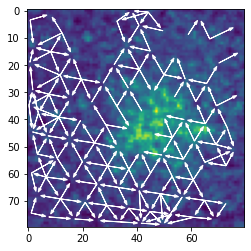

Big average latency: 3.6622368684
Big average latency: 18.241814118666664
Big average latency: 8.863009178333334
Big average latency: 5.19138958
Big average latency: 12.768938419999998
Big average latency: 4.1707181
Big average latency: 26.096517333333342
Big average latency: 3.5270915154999973
Big average latency: 5.671344034499993
Big average latency: 3.21540219
Big average latency: 18.512238483250005
Big average latency: 39.008310783000006
Big average latency: 7.214851424000008


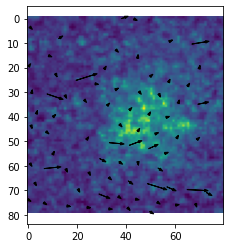

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01/ 02_01_01


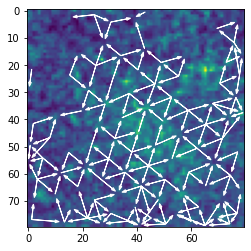

Big average latency: 3.057268009666665
Big average latency: 15.828706412000003
Big average latency: 3.4596997469999997
Big average latency: 3.4303073274999996
Big average latency: 4.125403200999998
Big average latency: 8.0804354725
Big average latency: 3.1460633489999967
Big average latency: 6.628629272499999
Big average latency: 7.4854705280000005
Big average latency: 9.836412233999996
Big average latency: 5.5147224360000004
Big average latency: 8.394313175999992
Big average latency: 3.252347908333332
Big average latency: 3.42009008
Big average latency: 6.941586684999997
Big average latency: 10.702502715999996
Big average latency: 4.688242703999994
Big average latency: 3.0844921250000024


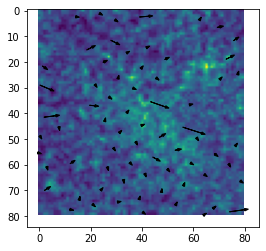

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03/ 02_01_03


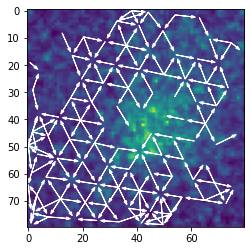

Big average latency: 4.3856897443333365
Big average latency: 3.0565126439999992
Big average latency: 12.425867521499997
Big average latency: 3.209645599999999
Big average latency: 7.550237676666667
Big average latency: 9.599953564499986
Big average latency: 3.0747227549999985
Big average latency: 3.677623666666666
Big average latency: 3.1742776560000014


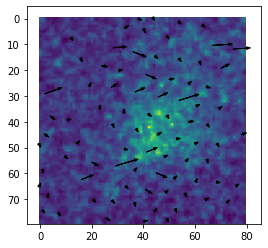

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02/ 02_01_02


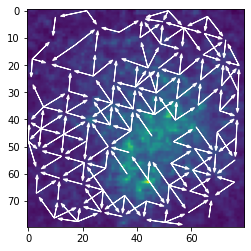

Big average latency: 3.0096722512499987
Big average latency: 3.043915172000002
Big average latency: 3.2687804240000005
Big average latency: 3.003800849333336


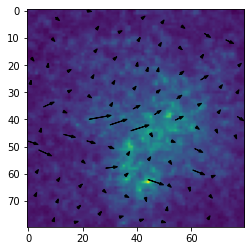

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04/ 02_01_04


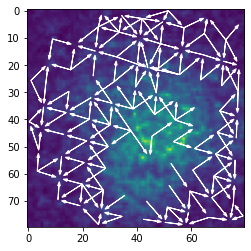

Big average latency: 7.622245022000003
Big average latency: 7.498496802400003


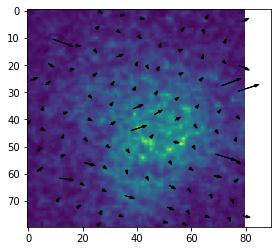

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/ 02_01_04


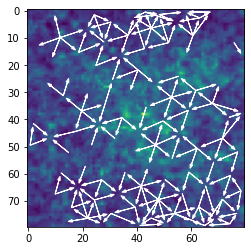

Big average latency: 3.4492405411999982
Big average latency: 9.347621016
Big average latency: 3.2536352456666653
Big average latency: 3.8355581289999927
Big average latency: 3.93869653485714
Big average latency: 4.507558613999983
Big average latency: 4.266331459999996


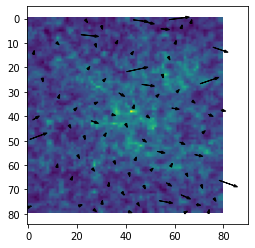

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/ 02_01_06


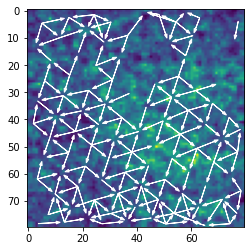

Big average latency: 3.291400807499995
Big average latency: 3.1266766520000027
Big average latency: 13.3263290512
Big average latency: 8.042804874999996
Big average latency: 4.212482493333341
Big average latency: 3.1557205199999974
Big average latency: 3.650675061000008


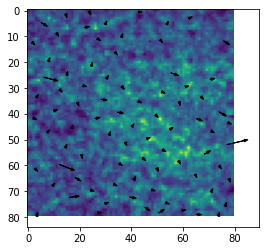

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02/ 02_02_02


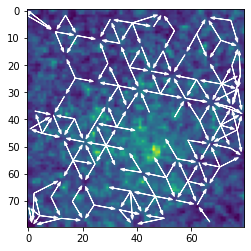

Big average latency: 3.237794185499999
Big average latency: 26.015322585
Big average latency: 21.256342115799995
Big average latency: 6.9476509099999975
Big average latency: 12.969934731
Big average latency: 6.723329150999998


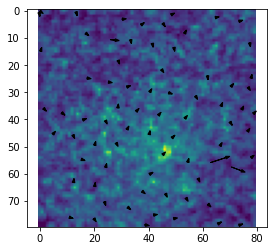

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02/ 02_02_02


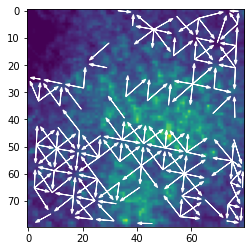

Big average latency: 15.296018588999996
Big average latency: 4.576543801
Big average latency: 3.2855941983333334
Big average latency: 8.766237368000002


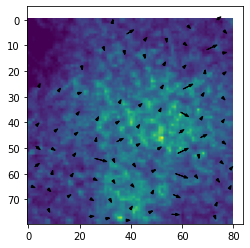

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/ 02_02_03


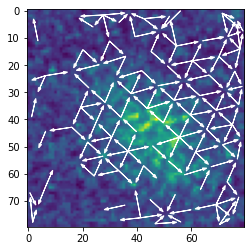

Big average latency: 3.119610981666667
Big average latency: 3.8680775000000027
Big average latency: 3.303248313333335
Big average latency: 14.575913985000009
Big average latency: 9.686368086000005
Big average latency: 4.686486075500001


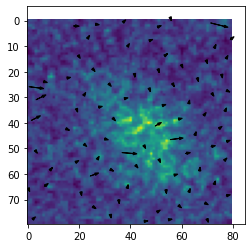

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05/ 02_03_05


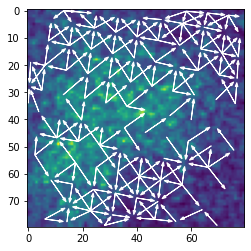

Big average latency: 3.236881025000008
Big average latency: 3.3248424666250016
Big average latency: 3.522525817000005
Big average latency: 4.038849622500004
Big average latency: 7.984814700000002
Big average latency: 3.478840326000002


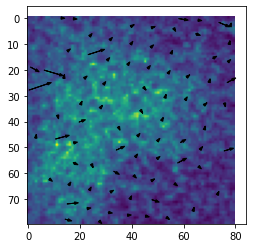

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08/ 02_03_08


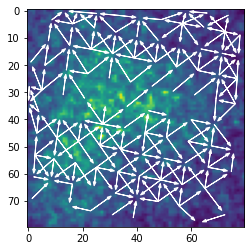

Big average latency: 3.124531485000004
Big average latency: 4.242413157000002
Big average latency: 3.237883719000002
Big average latency: 5.340563931600001
Big average latency: 41.33786929733333
Big average latency: 4.022297048
Big average latency: 18.874106168999997


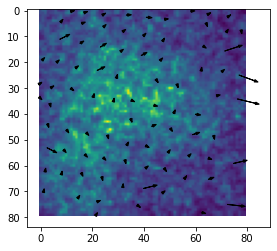

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/ 02_03_02


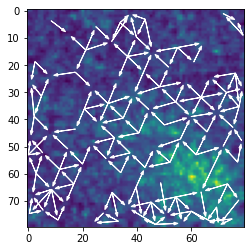

Big average latency: 5.050617617499998
Big average latency: 3.42225988
Big average latency: 6.561756720999997
Big average latency: 4.732679067999995
Big average latency: 11.292744031999991


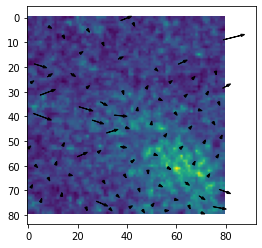

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/ 02_04_02


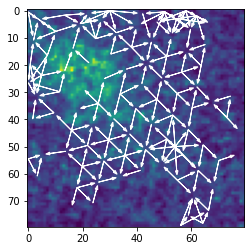

Big average latency: 3.0659540658333326
Big average latency: 7.220168162499997
Big average latency: 12.134637346800005
Big average latency: 23.50713178000001
Big average latency: 4.346185864000001
Big average latency: 11.552048939166667
Big average latency: 6.537534229999995
Big average latency: 4.076641710666664
Big average latency: 15.416493301799997
Big average latency: 3.780144014499996
Big average latency: 3.041536233749997
Big average latency: 3.4259963350000007
Big average latency: 3.2193070812000006
Big average latency: 3.0597270719999985
Big average latency: 3.493839368999998
Big average latency: 3.5652809666666676
Big average latency: 4.4305145249999995


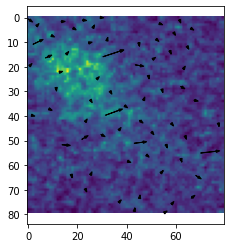

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/ 02_06_01


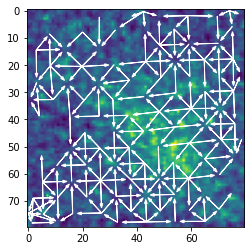

Big average latency: 3.209073346285709
Big average latency: 3.742198088750003
Big average latency: 4.248481396500001
Big average latency: 4.063512728000003
Big average latency: 10.105370971000003
Big average latency: 19.549095211999997
Big average latency: 3.0056529744000007
Big average latency: 13.967681990857146
Big average latency: 11.224187562000003
Big average latency: 3.6376098533333345
Big average latency: 13.317925502500001
Big average latency: 11.987002638571433


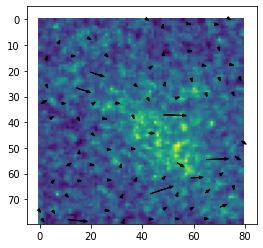

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/ 02_06_05


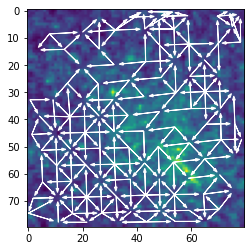

Big average latency: 5.920019956000002
Big average latency: 5.117782895333331
Big average latency: 8.782469855625001
Big average latency: 29.02229510400001
Big average latency: 14.925893913
Big average latency: 5.628244260800001
Big average latency: 8.608006990500002
Big average latency: 7.867083782999998
Big average latency: 3.7405390913999996
Big average latency: 9.075363328799998
Big average latency: 3.5624698019999985


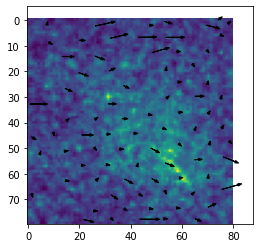

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/ 02_06_06


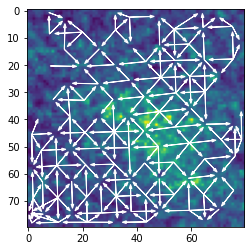

Big average latency: 4.348274246000001
Big average latency: 4.624284320000002
Big average latency: 3.067487402
Big average latency: 3.538989135499996
Big average latency: 3.334910520333333


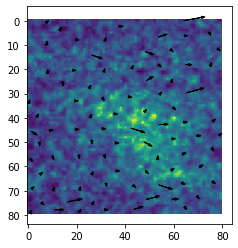

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01/ 03_01_01


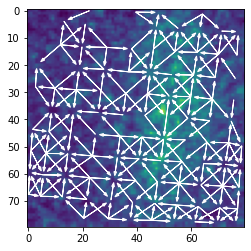

Big average latency: 27.454353495142854
Big average latency: 3.3824033774999966
Big average latency: 3.9420157488571452
Big average latency: 16.894555966124997
Big average latency: 3.2085254031999995
Big average latency: 3.496340366999998
Big average latency: 3.772817064000001
Big average latency: 5.894467544000002
Big average latency: 7.018680174999994
Big average latency: 3.1299663767142847
Big average latency: 4.303870353999999
Big average latency: 3.210174684
Big average latency: 4.102855574999995
Big average latency: 3.1615654933333306
Big average latency: 9.662382799999989


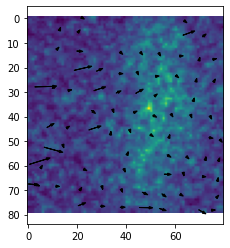

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03/ 03_01_03


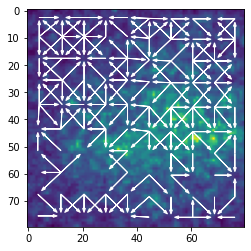

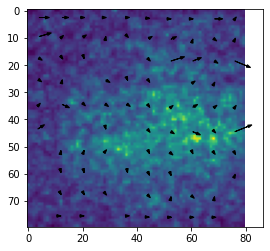

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05/ 03_01_05


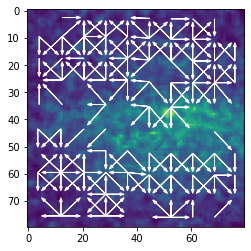

Big average latency: 3.2315975905714316


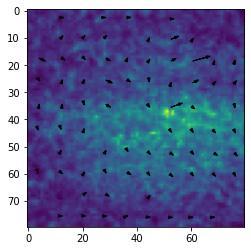

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08/ 03_01_08


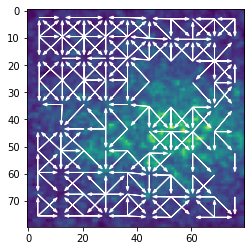

Big average latency: 3.2356822784
Big average latency: 3.1589447493750016
Big average latency: 3.4155631507500006
Big average latency: 4.910821263000002
Big average latency: 3.2153617237500027


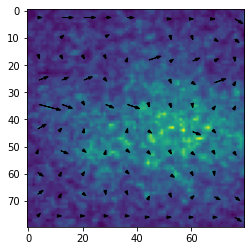

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01/ 03_02_01


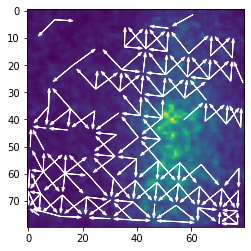

Big average latency: 3.1539138000000038
Big average latency: 3.751669740000008
Big average latency: 3.0013079600000006
Big average latency: 3.529144307500003
Big average latency: 3.3922397124999892
Big average latency: 3.3674043840000043
Big average latency: 3.2432323000000105
Big average latency: 7.256091014285723
Big average latency: 10.884001855999998
Big average latency: 5.048671451999998
Big average latency: 3.7988199035999988


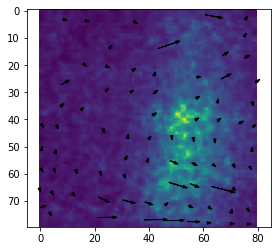

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02/ 03_02_02


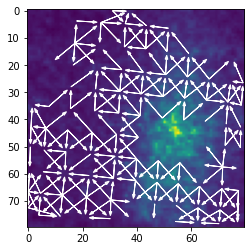

Big average latency: 3.3660493649999994
Big average latency: 4.053301499999997
Big average latency: 3.10343963571429
Big average latency: 9.333123939999998


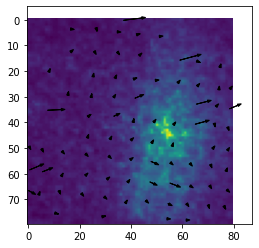

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12/ 03_02_12


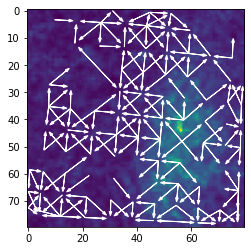

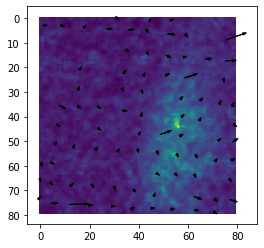

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02/ 03_04_02


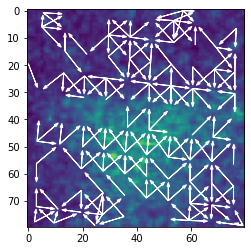

Big average latency: 3.3213768201999976
Big average latency: 7.163003060999998
Big average latency: 3.3343002860000084


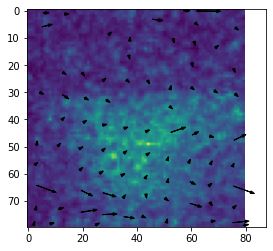

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06/ 03_04_06


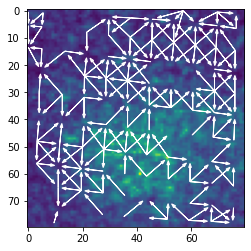

Big average latency: 3.9962420164285755
Big average latency: 3.190068649125002
Big average latency: 6.608681081600004
Big average latency: 6.802350110000009
Big average latency: 4.038431410000002
Big average latency: 4.882224407999993
Big average latency: 5.286211700000001
Big average latency: 3.3465782699999984
Big average latency: 3.375965697500001
Big average latency: 4.838487654000001
Big average latency: 3.4658522594285706


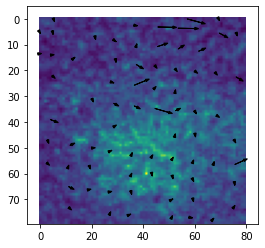

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01/ 06_01_01


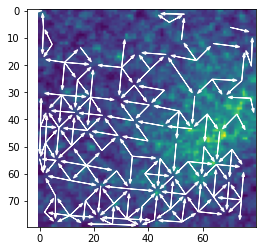

Big average latency: 3.566210890666666
Big average latency: 4.023308554
Big average latency: 3.1987497543999988
Big average latency: 4.286945777999999
Big average latency: 8.287092616499995
Big average latency: 8.350888176666666


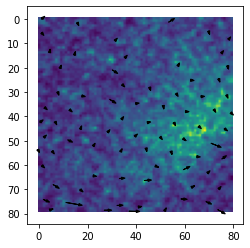

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03/ 06_01_03


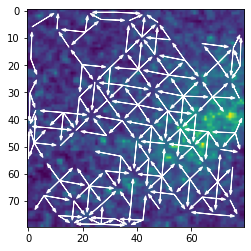

Big average latency: 3.9080056813999975
Big average latency: 3.308713847999999
Big average latency: 4.121092664000002
Big average latency: 5.807175429749998


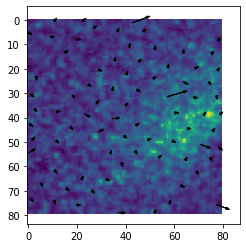

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06/ 06_01_06


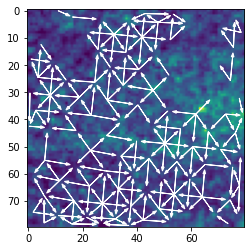

Big average latency: 23.990081852000003
Big average latency: 5.912980061999997


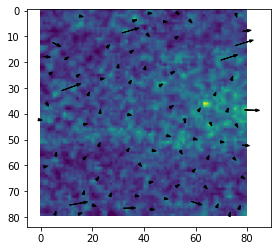

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07/ 01_01_07


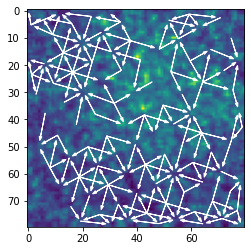

Big average latency: 13.411360226875
Big average latency: 19.291790431375
Big average latency: 4.754822909200001
Big average latency: 6.897457486666671


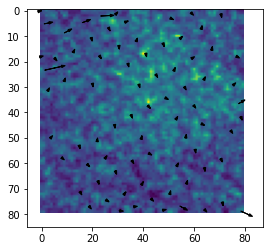

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05/ 01_02_05


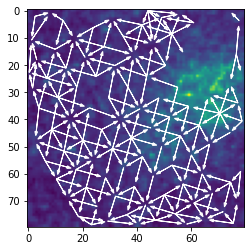

Big average latency: 3.234809311999999
Big average latency: 7.313622169999996
Big average latency: 3.7573224900000155
Big average latency: 7.631199943800001
Big average latency: 3.210372501
Big average latency: 6.635550912
Big average latency: 3.907037813333333
Big average latency: 3.8323468679999917
Big average latency: 3.591443282499998
Big average latency: 3.4099446709999985
Big average latency: 3.5932123149999984
Big average latency: 3.345673265999998


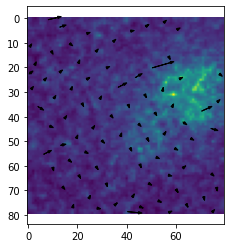

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03/ 01_03_03


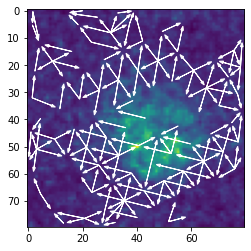

Big average latency: 5.494710611250007
Big average latency: 52.684693108333335
Big average latency: 31.421612774399996
Big average latency: 9.539686931000002
Big average latency: 4.648767186000002
Big average latency: 3.180013449
Big average latency: 3.2751148946666673


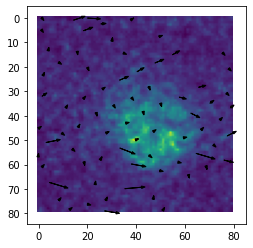

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04/ 01_03_04


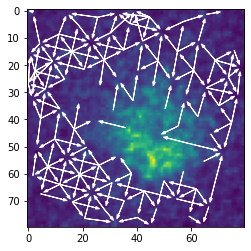

Big average latency: 15.858811602999983
Big average latency: 4.0948006262500005
Big average latency: 6.437244760000003
Big average latency: 5.417203465249997
Big average latency: 4.071971157000004
Big average latency: 21.36234575035
Big average latency: 20.381699359500004
Big average latency: 5.957564250000001
Big average latency: 5.446237255333332
Big average latency: 3.449080436249999
Big average latency: 4.075974772499999


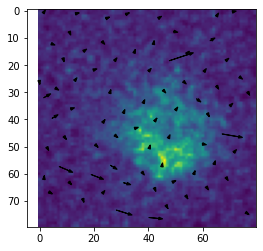

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02/ 01_04_02


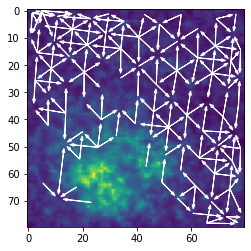

Big average latency: 8.258363089142854
Big average latency: 4.18749329
Big average latency: 8.169979100499997
Big average latency: 3.473389817333333
Big average latency: 5.2218250253333345
Big average latency: 4.318820181333331
Big average latency: 5.13459288485714
Big average latency: 4.065176790000001
Big average latency: 3.4590520571428574
Big average latency: 4.458899136999999
Big average latency: 6.724228373499995
Big average latency: 3.391505443500001
Big average latency: 3.8759568795000017


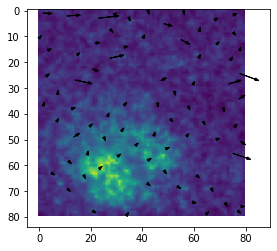

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05/ 01_05_05


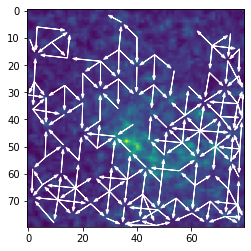

Big average latency: 5.814036591999997
Big average latency: 10.947671031999995


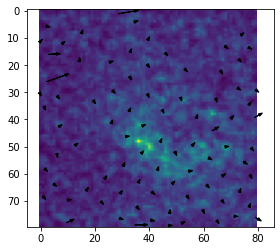

	slice directory count: 35


In [7]:
## filter out no-response grid squares by SNR cutoff (or manual inspection?)
###   Read in the SNR/latency files/roi center files
slice_count = 0
for slic in image_data:
    for loc in image_data[slic]:
        for rec in image_data[slic][loc]:
            for subdir in image_data[slic][loc][rec]:
                slice_count += 1
                def pad_z2(x):
                    x = str(x)
                    while len(x) < 2:
                        x = '0' + x
                    return x
                
                rec_id = pad_z2(slic) + "_" + pad_z2(loc) + "_" + pad_z2(rec)
                
                filename_end = "_rois_" + rec_id + ".dat"
                snr_filename = subdir + "/" + "SNR_" + filename_end
                latency_filename = subdir + "/" + "latency_" + filename_end 
                roi_center_filename = subdir + "/" + rois_centers_filenames


                snr_df = pd.read_csv(snr_filename, sep='\t', header=None,
                                     names=['Index',  'SNR'])
                latency_df = pd.read_csv(latency_filename, sep='\t', header=None,
                                     names=['ROI Index',  'Latency'])
                roi_center_df = pd.read_csv(roi_center_filename, sep='\t', header=None,
                                     names=['Center x',  'Center y'])
                
                combined_df = roi_center_df.join(latency_df)
                combined_df = combined_df.join(snr_df[['SNR']])
                print(subdir, rec_id)
                
                ############## Analysis: ############################
                ##### 1) directed graph analysis of latency #########
                ##### 2) 3-D plot of latency ########################
                ##### 3) 3-D plot of SNR ############################
                #####################################################
                
                # 1) directed graph analysis of latency
                nd_list = [Node([row[['Center x']][0], row[['Center y']][0]],
                                 row[['Latency']][0],
                                 row[['SNR']][0]) for _, row in combined_df.iterrows()]
                grid = Grid(nd_list, n_sq, latency_tolerance=latency_tolerance)
                
                ## a) determine latency ordering on directed graph
                grid.populate_latency_matrix()
                grid.calculate_current_field()  # current flow vectors of all nodes
                
                ## b) visualize
                snr_map = None
                try:
                    snr_map = image_data[slic][loc][rec][subdir]['snr_map']
                except Exception as e:
                    snr_map = np.zeros((80, 80))  # default
                grid.visualize_spatial_flow(snr_map=snr_map,
                                            save_dir=subdir+"GridVisual1"+name_parse+'.png')
                grid.visualize_current_field(snr_map=snr_map,
                                            save_dir=subdir+"GridVisual2"+name_parse+'.png',
                                            min_lat=0.1, 
                                            max_lat=3.0)
                
                
print("\tslice directory count:", slice_count) 